In [15]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.15)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_slf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),('rf', rnd_clf),('svc', svm_slf)],
    voting='hard'
)
voting_clf.fit(X, y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [17]:
from sklearn.metrics import accuracy_score
Xte, yte = make_moons(n_samples=200, noise=0.15)
for clf in (log_clf, rnd_clf, svm_slf, voting_clf):
    clf.fit(X,y)
    y_pred = clf.predict(Xte)
    print(clf.__class__.__name__, accuracy_score(yte, y_pred))

LogisticRegression 0.89
RandomForestClassifier 0.99
SVC 0.98
VotingClassifier 0.98


In [32]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
X, y = make_moons(n_samples=1000, noise=0.30)
Xte, yte = make_moons(n_samples=200, noise=0.30)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, 
)

tree_clf = DecisionTreeClassifier()

bag_clf.fit(X, y)
tree_clf.fit(X,y)
y_pred = bag_clf.predict(Xte)
y_pred_tree = tree_clf.predict(Xte)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

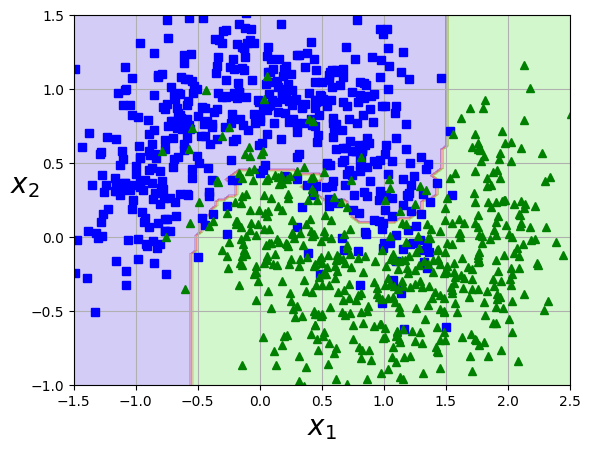

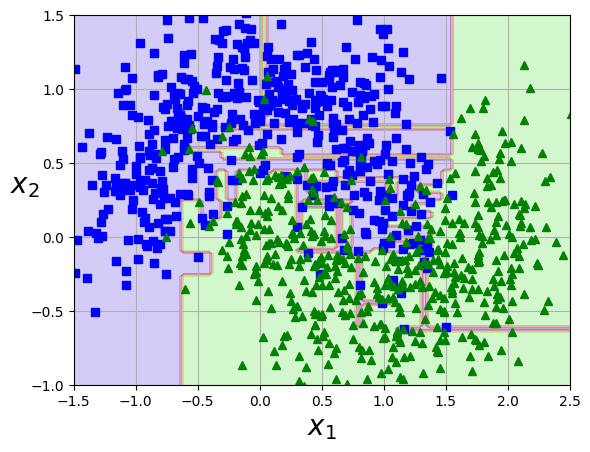

In [34]:
plot_predictions(bag_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

plot_predictions(tree_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [35]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16)
rnd_clf.fit(X, y)
y_pred_rf = rnd_clf.predict(Xte)
print(np.sum(y_pred_rf == yte)/len(yte))

0.91


In [36]:
#feature importances

from sklearn.datasets import load_iris

iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09527478064734375
sepal width (cm) 0.022197141636547593
petal length (cm) 0.4296568251810674
petal width (cm) 0.4528712525350413


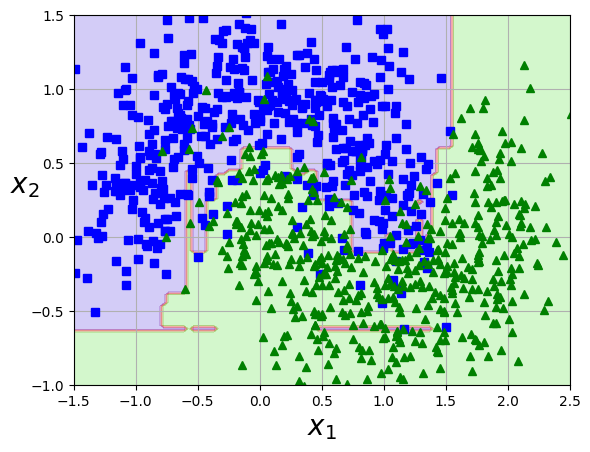

In [38]:
#adaptive boosting
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X, y)
plot_predictions(ada_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [41]:
#gradient boosting
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

y_pred = sum(tree.predict(Xte) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [49]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

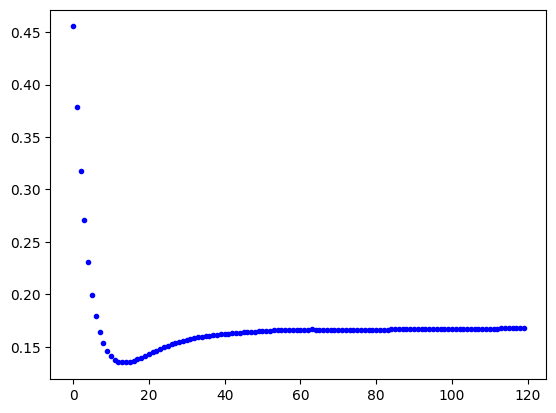

In [62]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(iris['data'], iris['target'])
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

plt.plot(errors, 'b.')
plt.show()


In [63]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1,120):
    gbrt.n_estimators_ = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break